# Fitting TESS data

In [1]:
import exoplanet

import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits

%matplotlib inline

plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

In [2]:
search_result = lk.search_lightcurve('TIC 445859771', author='SPOC')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,445859771,0.0
1,TESS Sector 22,2020,SPOC,120,445859771,0.0
2,TESS Sector 23,2020,SPOC,120,445859771,0.0
3,TESS Sector 48,2022,SPOC,120,445859771,0.0


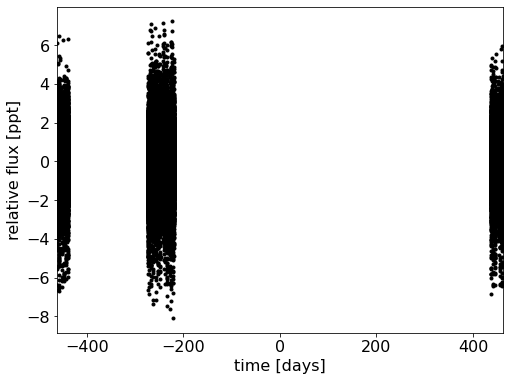

In [3]:
lc_file = lk.search_lightcurve('TIC 445859771', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch(lambda x: x.remove_nans().normalize().remove_outliers())
time = lc.time.value
flux = lc.flux


with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

plt.plot(x, y, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

In [4]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(x, y, yerr)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('bls depth error:', bls_power.depth_err[index])
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)

bls period: 4.631316790471438
bls t0: -461.34256457198444
bls depth: 2.040957112079421
bls depth error: 0.041316877865180957
ref_time: 2173.6753273248096
epoch: 1712.3327627528251


In [5]:
print('bls depth error:', bls_power.depth_err[index])

bls depth error: 0.041316877865180957


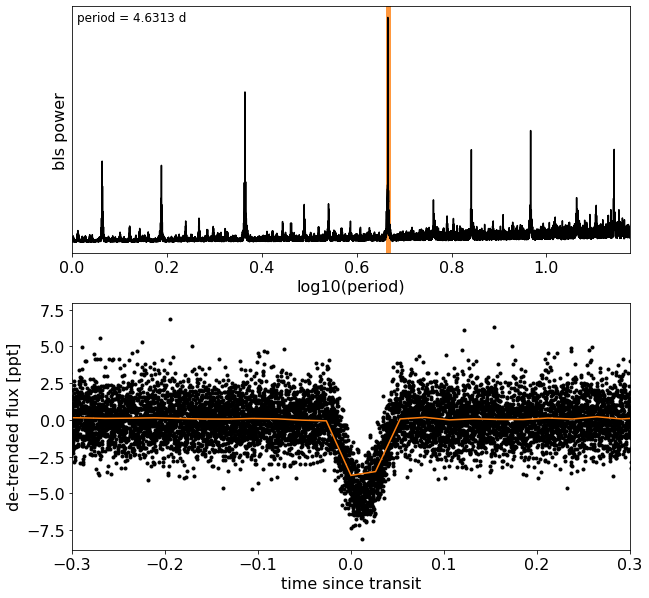

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold, y, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

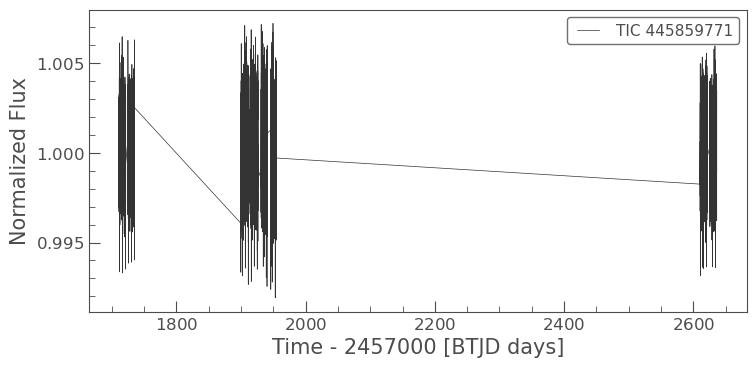

In [7]:
lc.plot();

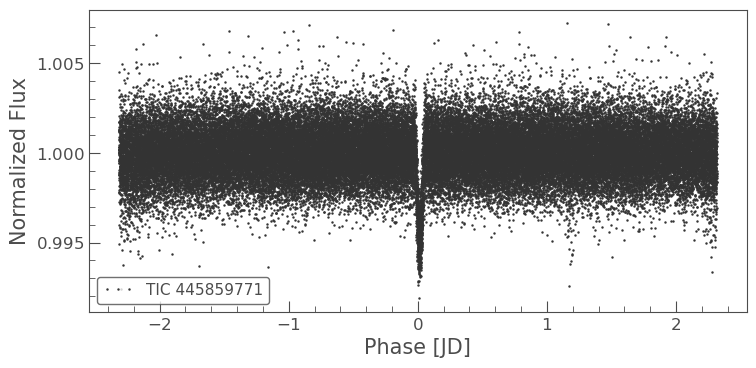

In [8]:
lc_folded = lc.fold(period = bls_period, epoch_time = bls_t0+ref_time)
lc_folded.plot(marker='.', markersize=1.5,ls='');
#plt.savefig('toi_1273_tess_data_folded.png',dpi=400,bbox_inches='tight')
#plt.xlim(-0.1,0.1)

In [9]:
lc_folded.time

<TimeDelta object: scale='None' format='jd' value=[-2.31560872 -2.31550119 -2.315435   ...  2.315456    2.31551801
  2.31555608]>

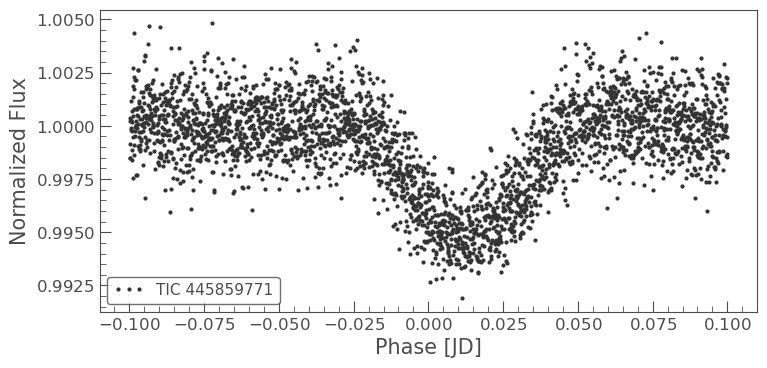

In [10]:
lc_folded_truncate = lc_folded.truncate(before = -0.1, after= 0.1, column = 'time')
_ = lc_folded.truncate(before = -0.1, after= 0.1, column = 'time').plot(marker='o', ls='')
#plt.savefig('toi_1273_folded_trunc.png',dpi=400,bbox_inches='tight')

## The transit model in PyMC3

In [11]:
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

In [12]:
phase_lc = np.linspace(-0.3, 0.3, 100)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from exofop
        M_star = 1.015, 0.12369
        R_star = 1.06597, 0.0499146
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star[0], sd=M_star[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star[0], sd=R_star[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)
        period = pm.Deterministic("period", tt.exp(log_period))

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)


        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
            * 1e3
        )
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


model0, map_soln0, extras0 = build_model()

['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/ho

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -108336.59019522392 -> -107838.79703669758


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_depth]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -107838.79703669758 -> -107835.77465599183


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -107835.77465599182 -> -107338.31498574882


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [t0, log_period]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Desired error not necessarily achieved due to precision loss.
logp: -107338.3149857488 -> -107133.95597821935


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/ho

optimizing logp for variables: [u_star]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -107133.95597821935 -> -107107.49628479741


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_depth]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -107107.49628479741 -> -106557.92762286932


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -106557.92762286932 -> -106391.86584128524


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ecs]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -106391.86584128524 -> -106347.41507318126


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [mean]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -106347.41507318126 -> -106347.19213398217


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Desired error not necessarily achieved due to precision loss.
logp: -106347.19213398217 -> -106308.59866930192


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Desired error not necessarily achieved due to precision loss.
logp: -106308.5986693019 -> -106090.62385115166


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


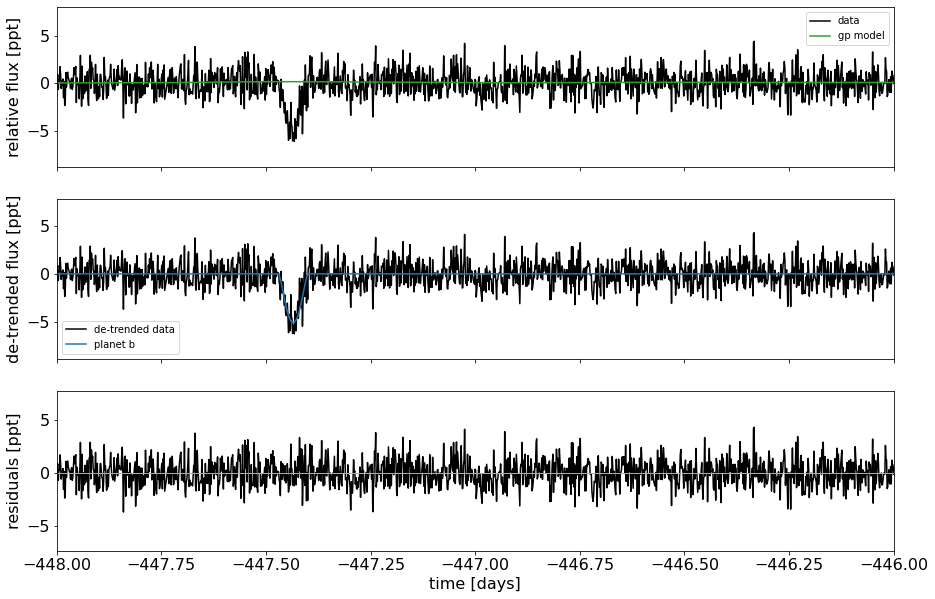

In [13]:
# We plot the initial light curve model:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = extras["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    plt.xlim(-448,-446)
    return fig


_ = plot_light_curve(map_soln0, extras0)

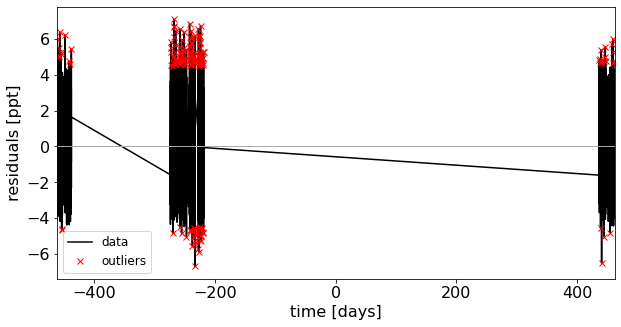

In [14]:
# We can do some sigma clipping to remove significant outliers.
mod = (
    extras0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(extras0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask1 = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask1], resid[~mask1], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())
#plt.xlim(-450,-435)

2946
60851
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -104722.11653123678 -> -104701.75395965157


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_depth]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Desired error not necessarily achieved due to precision loss.
logp: -104701.75395965157 -> -104701.74363707639


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Desired error not necessarily achieved due to precision loss.
logp: -104701.74363707639 -> -104701.74349635887


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [t0, log_period]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Desired error not necessarily achieved due to precision loss.
logp: -104701.74349635887 -> -104701.74343137049


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [u_star]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -104701.7434313705 -> -104701.74230075323


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_depth]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -104701.74230075323 -> -104701.74225742274


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -104701.74225742274 -> -104701.74222925307


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ecs]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -104701.74222925307 -> -104701.74214249336


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [mean]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -104701.74214249336 -> -104701.68990293294


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Desired error not necessarily achieved due to precision loss.
logp: -104701.68990293294 -> -104701.68978068045


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Desired error not necessarily achieved due to precision loss.
logp: -104701.68978068045 -> -104701.68929263217


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


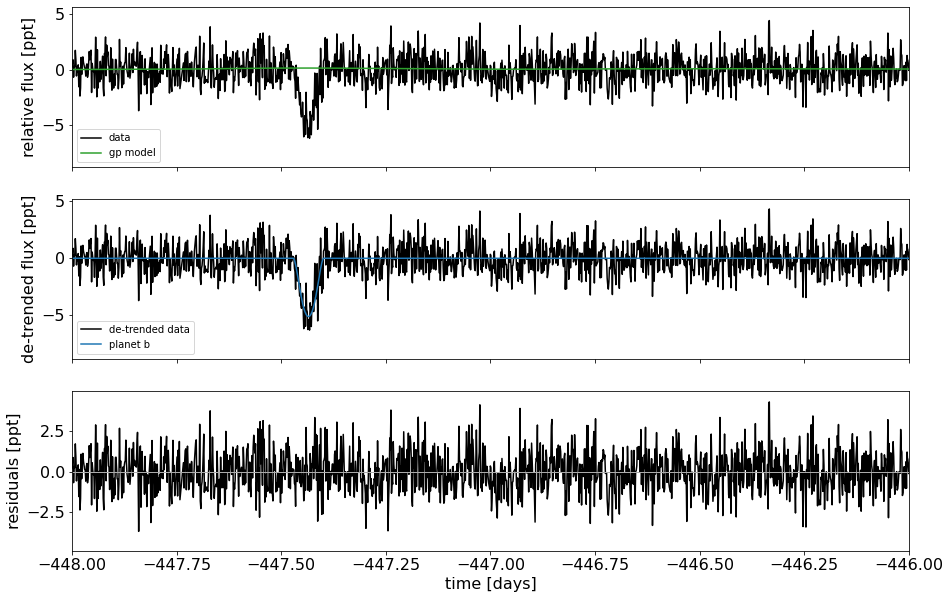

In [15]:
# And then we re-build the model using the data without outliers.
# Also I'm adding a mask to reduce the amount of points, droping everithin outside 0.1d from transit
print(len(lc_folded_truncate))
m1 = np.abs(np.modf(((bls_t0+ref_time)-lc.time.value)/bls_period)[0]) < 0.021592
m2 = np.abs(np.modf(((bls_t0+ref_time)-lc.time.value)/bls_period)[0]) > 0.97840
mask2 = m1 | m2
#mask = mask1 & mask2
mask = mask1
print(mask.sum())
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

In [16]:
# Now that we have the model, we can sample:

with model:
    trace = pmx.sample(
        tune=3000, #1500,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95, #0.95,
        return_inferencedata=True,
        random_seed=[261136679, 261136680],
        init="adapt_full",
    )

['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 14395 seconds.


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/ho

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [17]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "period",
        "r_star",
        "m_star",
        "u_star",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
omega,0.020,1.826,-3.055,2.975,0.055,0.059,1094.0,473.0,1172.0,1125.0,1.00
ecc,0.141,0.128,0.001,0.389,0.007,0.006,369.0,264.0,595.0,300.0,1.00
r_pl,0.111,0.014,0.085,0.135,0.001,0.000,669.0,644.0,701.0,851.0,1.00
b,0.959,0.025,0.918,0.997,0.001,0.001,642.0,640.0,618.0,844.0,1.00
t0,-461.329,0.001,-461.331,-461.326,0.000,0.000,248.0,248.0,334.0,307.0,1.00
period,4.631,0.000,4.631,4.631,0.000,0.000,2296.0,2296.0,2307.0,1263.0,1.00
r_star,1.062,0.046,0.972,1.143,0.001,0.001,1672.0,1670.0,1662.0,1604.0,1.00
m_star,1.020,0.117,0.794,1.237,0.003,0.002,1730.0,1730.0,1722.0,1361.0,1.00
u_star[0],0.711,0.459,0.002,1.506,0.012,0.009,1499.0,1308.0,1385.0,979.0,1.00
u_star[1],0.024,0.431,-0.742,0.801,0.011,0.010,1543.0,847.0,1502.0,1083.0,1.01


In [18]:
radio = trace.posterior["r_pl"].mean().item()*109.076
radio_err = trace.posterior["r_pl"].std().item()*109.076
periodo = trace.posterior['period'].mean().item()
periodo_sigma = trace.posterior['period'].std().item()
print("Radio = {r:.3f} \u00B1 {r_err:.3f}".format(r=radio, r_err=radio_err))
print("Periodo = {p:.5f} \u00B1 {p_s:.6f}".format(p=periodo, p_s=periodo_sigma))

Radio = 12.060 ± 1.519
Periodo = 4.63130 ± 0.000004


## Results

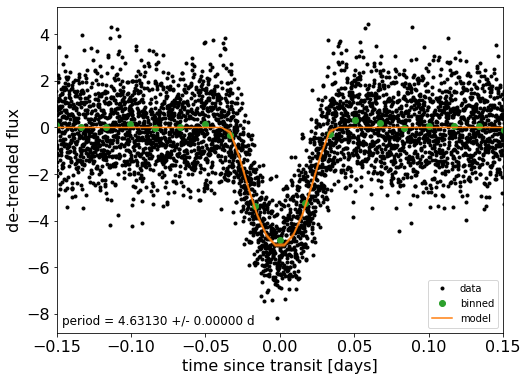

In [19]:
# After sampling, we can make the usual plots.
# First, let's look at the folded light curve plot:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
gp_mod = extras["gp_pred"] + map_soln["mean"]  # np.median(
#     flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
# )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(
    0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned"
)

# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc, pred[1], color="C1", label="model")
art = plt.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values)
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
_ = plt.xlim(-0.15, 0.15)

And a corner plot of some of the key parameters:

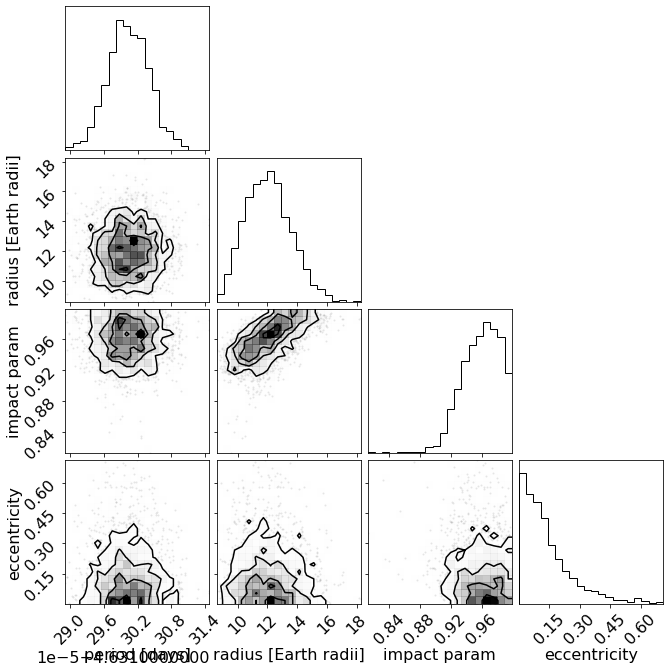

In [20]:
import corner
import astropy.units as u

trace.posterior["r_earth"] = (
    trace.posterior["r_pl"].coords,
    (trace.posterior["r_pl"].values * u.R_sun).to(u.R_earth).value,
)

_ = corner.corner(
    trace,
    var_names=["period", "r_earth", "b", "ecc"],
    labels=[
        "period [days]",
        "radius [Earth radii]",
        "impact param",
        "eccentricity",
    ],
)